In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import os,sys
import numpy as np
from salishsea_tools import viz_tools, geo_tools
%matplotlib inline

In [2]:
# Test with vector (10,0)
u,v=10,0
m=np.sqrt(u**2+v**2)
a=np.arctan2(v,u)
print("mag:",m," angle:",a," angle degrees:",a*180/np.pi)

# Rotate by 29 degrees
a2=a+np.radians(29)
u2,v2 = m*np.cos(a2), m*np.sin(a2)
print("rotated vector:",u2,', ',v2)

mag: 10.0  angle: 0.0  angle degrees: 0.0
rotated vector: 8.74619707139 ,  4.84809620246


In [3]:
# Now use viz tools (which should rotate by 29 deg)
print(viz_tools.rotate_vel(u,v,'map'))
print(viz_tools.rotate_vel(u,v,'grid'))

(8.7461970713939579, -4.8480962024633705)
(8.7461970713939579, 4.8480962024633705)


In [4]:
# Compressed Fraser region grid
fname = '/home/mdunphy/MEOPAR/NEMO-forcing/grid/coordinates_seagrid_SalishSea201702.nc'
with nc.Dataset(fname, 'r') as cnc:
    glamt = cnc.variables['glamt'][0,...]; gphit = cnc.variables['gphit'][0,...]
    glamu = cnc.variables['glamu'][0,...]; gphiu = cnc.variables['gphiu'][0,...]
    glamv = cnc.variables['glamv'][0,...]; gphiv = cnc.variables['gphiv'][0,...]
    glamf = cnc.variables['glamf'][0,...]; gphif = cnc.variables['gphif'][0,...]
# First point
xA = glamu[0:-2,0:-2]
yA = gphiu[0:-2,0:-2]
# Second point
xB = glamu[0:-2,1:-1]
yB = gphiu[0:-2,1:-1]
# Third point: same longitude as second point, same latitude as first point
xC = xB
yC = yA

In [5]:
# Find angle by spherical trig
# https://en.wikipedia.org/wiki/Solution_of_triangles#Three_sides_given_.28spherical_SSS.29
R = 6367  # from geo_tools.haversine
a = geo_tools.haversine(xB,yB,xC,yC) / R
b = geo_tools.haversine(xA,yA,xC,yC) / R
c = geo_tools.haversine(xA,yA,xB,yB) / R
cosA = (np.cos(a) - np.cos(b)*np.cos(c))/(np.sin(b)*np.sin(c))
#cosB = (np.cos(b) - np.cos(c)*np.cos(a))/(np.sin(c)*np.sin(a))
#cosC = (np.cos(c) - np.cos(a)*np.cos(b))/(np.sin(a)*np.sin(b))
A = np.degrees(np.arccos(cosA)) # A is the angle counterclockwise from from due east
#B = np.degrees(np.arccos(cosB))
#C = np.degrees(np.arccos(cosB))

In [6]:
def calculate_initial_compass_bearing(pointA, pointB):
    ''' The bearing between two points is calculated.
       
    θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ )
    φ1,λ1 is the start point
    φ2,λ2 the end point 
    
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    '''
    
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = np.radians(pointA[0])
    lat2 = np.radians(pointB[0])
    
    diffLong = np.radians(pointB[1] - pointA[1])

    x = np.sin(diffLong) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1)
            * np.cos(lat2) * np.cos(diffLong))

    initial_bearing = np.arctan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [7]:
Bearing=calculate_initial_compass_bearing((yA,xA),(yB,xB))  # Measured clockwise from due north

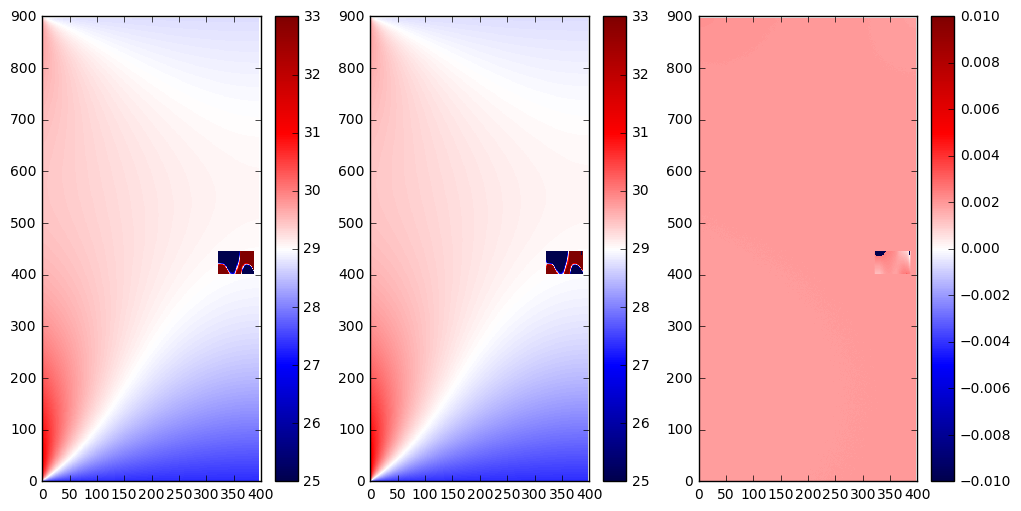

In [8]:
plt.figure(figsize=(12,6)); 
plt.subplot(1,3,1); plt.pcolormesh(A, vmin=25, vmax=33, cmap='seismic'); plt.colorbar()
plt.subplot(1,3,2); plt.pcolormesh(90-Bearing, vmin=25, vmax=33, cmap='seismic'); plt.colorbar()
plt.subplot(1,3,3); plt.pcolormesh(90-Bearing-A, vmin=-0.01, vmax=0.01, cmap='seismic'); plt.colorbar()